In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import re
import datetime as dt

In [2]:
def get_design_matrix4timeseries(date12_list, refDate=None):
        """Return design matrix of the input ifgramStack for timeseries estimation
        Parameters: date12_list - list of string in YYYYMMDD_YYYYMMDD format
                    refDate     - str, date in YYYYMMDD format
                                  set to None for the 1st date
                                  set to 'no' to disable reference date
        Returns:    A - 2D array of float32 in size of (num_ifgram, num_date-1)
                    B - 2D array of float32 in size of (num_ifgram, num_date-1)
        Examples:   obj = ifgramStack('./inputs/ifgramStack.h5')
                    A, B = obj.get_design_matrix4timeseries(obj.get_date12_list(dropIfgram=True))
                    A = ifgramStack.get_design_matrix4timeseries(date12_list, refDate='20101022')[0]
                    A = ifgramStack.get_design_matrix4timeseries(date12_list, refDate=0)[0] #do not omit the 1st column
        """
        # Date info
        date12_list = list(date12_list)
        date1s = [i.split('_')[0] for i in date12_list]
        date2s = [i.split('_')[1] for i in date12_list]
        date_list = sorted(list(set(date1s + date2s)))
        num_ifgram = len(date12_list)
        num_date = len(date_list)

        # tbase in the unit of years
        # date_format = ptime.get_date_str_format(date_list[0])
        date_format = get_date_str_format(date_list[0])
        dates = np.array([dt.datetime.strptime(i, date_format) for i in date_list])
        tbase = [i.days + i.seconds / (24 * 60 * 60) for i in (dates - dates[0])]
        tbase = np.array(tbase, dtype=np.float32) / 365.25

        # calculate design matrix
        A = np.zeros((num_ifgram, num_date), np.float32)
        B = np.zeros((num_ifgram, num_date), np.float32)
        for i in range(num_ifgram):
            ind1, ind2 = [date_list.index(d) for d in date12_list[i].split('_')]
            A[i, ind1] = -1
            A[i, ind2] = 1
            B[i, ind1:ind2] = tbase[ind1+1:ind2+1] - tbase[ind1:ind2]

        # Remove reference date as it can not be resolved
        if refDate != 'no':
            # default refDate
            if refDate is None:
                refDate = date_list[0]

            # apply refDate
            if refDate:
                ind_r = date_list.index(refDate)
                A = np.hstack((A[:, 0:ind_r], A[:, (ind_r+1):]))
                B = B[:, :-1]

        return A, B


def get_date_str_format(date_str):
    """Get the datetime string format as defined in:
    https://docs.python.org/3.7/library/datetime.html#strftime-and-strptime-behavior
    Parameters: date_str - str, date in one of the following formats:
                            YYYYMMDDTHHMM
                            YYYYMMDD
                            YYMMDD
    Returns:    date_str_format - str, datetime string format
    """
    if isinstance(date_str, list):
        date_str = date_str[0]

    try:
        date_str = date_str.decode('utf8')
    except:
        pass

    date_str_format = None
    if len(re.findall('\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}', date_str)) > 0:
        date_str_format = '%Y-%m-%dT%H:%M:%S'

    elif len(re.findall('\d{4}-\d{2}-\d{2}T\d{2}:\d{2}', date_str)) > 0:
        date_str_format = '%Y-%m-%dT%H:%M'

    elif len(re.findall('\d{4}-\d{2}-\d{2}T\d{2}', date_str)) > 0:
        date_str_format = '%Y-%m-%dT%H'

    elif len(re.findall('\d{4}-\d{2}-\d{2}T', date_str)) > 0:
        date_str_format = '%Y-%m-%d'

    elif len(re.findall('\d{8}T\d{6}', date_str)) > 0:
        date_str_format = '%Y%m%dT%H%M%S'

    elif len(re.findall('\d{8}T\d{4}', date_str)) > 0:
        date_str_format = '%Y%m%dT%H%M'

    elif len(re.findall('\d{6}T\d{4}', date_str)) > 0:
        date_str_format = '%y%m%dT%H%M'

    elif len(re.findall('\d{8}', date_str)) > 0:
        date_str_format = '%Y%m%d'

    elif len(re.findall('\d{6}', date_str)) > 0:
        date_str_format = '%y%m%d'

    else:
        raise ValueError('un-recognized date string format for "{}"!'.format(date_str))

    return date_str_format

def get_zero_ifg_date_ranges(df):
    # find the gaps
    n_ifgs = pd.DataFrame({'n_valid':0},index=pd.date_range(desc.date1.min(),desc.date2.max()))

    for i,row in desc.iterrows():
        date_range = pd.date_range(row.date1,row.date2)
        if row.coherence > 0.4:
            n_ifgs.loc[df.index.isin(date_range),'n_valid'] += 1

    zero = n_ifgs.loc[n_ifgs.n_valid<1].copy()
    date = pd.Series(zero.index)
    offset = [0] + list((zero.index[1:] - zero.index[:-1]).days)
    jumps = [0]+[x for x,y in enumerate(offset) if y > 1] + [len(zero)]

    intervals = pd.DataFrame(columns=['start','end','length'])
    for i in range(len(jumps)-1):
        d1 = zero.index[jumps[i]]
        d2 = zero.index[jumps[i+1]-1]
        length = d2-d1
        intervals = intervals.append({'start':d1,'end':d2,'length':length},ignore_index=True)

    return intervals

In [3]:
cd /home/micromamba/data

/home/micromamba/data


In [4]:
files = list(Path().glob('coherenceSpatialAvg*txt'))

In [5]:
files

[PosixPath('coherenceSpatialAvg_asclower.txt'),
 PosixPath('coherenceSpatialAvg_ascupper.txt'),
 PosixPath('coherenceSpatialAvg_desclower.txt'),
 PosixPath('coherenceSpatialAvg_descupper.txt')]

In [6]:
dsets = {}

for fname in files:
    with open(fname) as f:
        lines = f.readlines()
    
    name = fname.stem.split('_')[1]
    
    size = lines[2]
    _,_,x,y = re.search(r'\((.*?)\)',size).group(1).strip().split(',')

    cols = [x for x in lines[4].strip().strip('#').split('\t') if x != '']
    
    dsets[name] = {'size':float(x)*float(y),'cols':cols}
    
    df = pd.read_csv(fname, sep='\t', names=cols, skiprows=5)
    df = df.drop(columns=['Num'])
    df['size'] = float(x) * float(y)
    
    dsets[name] = df

In [7]:
asc = dsets['asclower'].set_index('DATE12').join(
    dsets['ascupper'].drop(columns=['Btemp/days', 'Bperp/m']).set_index('DATE12'),
    lsuffix='_lower', rsuffix='_upper').reset_index()

desc = dsets['desclower'].set_index('DATE12').join(
    dsets['descupper'].drop(columns=['Btemp/days', 'Bperp/m']).set_index('DATE12'),
    lsuffix='_lower', rsuffix='_upper').reset_index()

In [8]:
asc['coherence'] = ((asc.Mean_lower * asc.size_lower) + (asc.Mean_upper * asc.size_upper)) / (asc.size_lower + asc.size_upper)
desc['coherence'] = ((desc.Mean_lower * desc.size_lower) + (desc.Mean_upper * desc.size_upper)) / (desc.size_lower + desc.size_upper)

In [9]:
drops = ['Mean_lower', 'size_lower','Mean_upper','size_upper']
asc = asc.drop(columns=drops)
desc = desc.drop(columns=drops)

In [10]:
asc[['date1','date2']] = asc.DATE12.str.split('_', 1, expand=True)
desc[['date1','date2']] = desc.DATE12.str.split('_', 1, expand=True)

asc['date1'] = pd.to_datetime(asc.date1)
asc['date2'] = pd.to_datetime(asc.date2)

desc['date1'] = pd.to_datetime(desc.date1)
desc['date2'] = pd.to_datetime(desc.date2)

In [11]:
asc.to_csv('ascending_ifgs.csv')
desc.to_csv('descending_ifgs.csv')

### Create n Ifgs graph

In [15]:
def get_zero_ifg_date_ranges(ifgs):
    # find the gaps
    n_ifgs = pd.DataFrame({'n_valid':0},index=pd.date_range(ifgs.date1.min(),ifgs.date2.max()))

    for i,row in ifgs.iterrows():
        date_range = pd.date_range(row.date1,row.date2)
        if row.coherence > 0.4:
            n_ifgs.loc[n_ifgs.index.isin(date_range),'n_valid'] += 1

        zero = n_ifgs.loc[n_ifgs.n_valid<1].copy()
        date = pd.Series(zero.index)
        offset = [0] + list((zero.index[1:] - zero.index[:-1]).days)
        jumps = [0]+[x for x,y in enumerate(offset) if y > 1] + [len(zero)]

        intervals = pd.DataFrame(columns=['start','end','length'])
        for i in range(len(jumps)-1):
            d1 = zero.index[jumps[i]]
            d2 = zero.index[jumps[i+1]-1]
            length = d2-d1
            intervals = intervals.append({'start':d1,'end':d2,'length':length},ignore_index=True)

    return n_ifgs, intervals

In [43]:
desc_n_ifgs, desc_intervals = get_zero_ifg_date_ranges(desc)
asc_n_ifgs, asc_intervals = get_zero_ifg_date_ranges(asc)

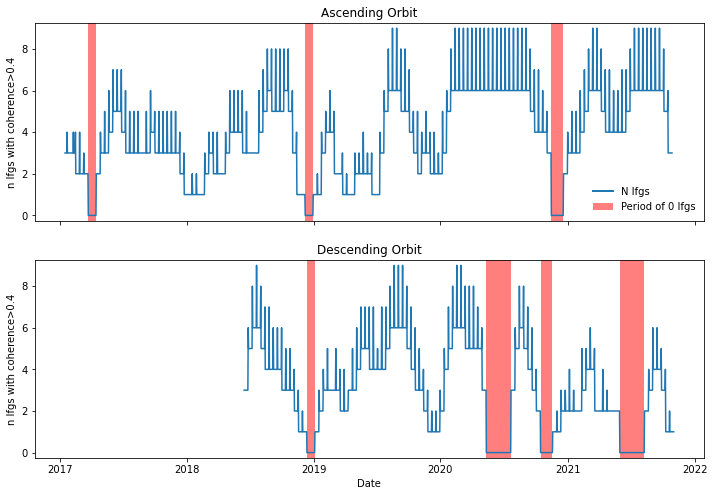

In [42]:
f, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8),sharex=True,sharey=True)

# Ascending
ax1.plot(asc_n_ifgs.index,asc_n_ifgs.n_valid)
ax1.set(ylabel='n Ifgs with coherence>0.4',title='Ascending Orbit',ylim=(-0.25,9.25))
for i,row in asc_intervals.iterrows():
    ax1.add_patch(Rectangle((row.start, -1), row.length, 12,facecolor=(1,0,0,0.5)))

legend_elements = [Line2D([0],[0],lw=2,label='N Ifgs'),
                  Patch(facecolor=(1,0,0,0.5), label='Period of 0 Ifgs')]
ax1.legend(handles=legend_elements,frameon=False)

# Descending
ax2.plot(desc_n_ifgs.index,desc_n_ifgs.n_valid)
ax2.set(xlabel='Date',ylabel='n Ifgs with coherence>0.4',title='Descending Orbit',ylim=(-0.25,9.25))
for i,row in desc_intervals.iterrows():
    ax2.add_patch(Rectangle((row.start, -1), row.length, 12,facecolor=(1,0,0,0.5)))

### Optionally Create Baseline Graph

In [ ]:
date12_list = list(desc.DATE12)
r_dates = [i.split('_')[0] for i in date12_list]
s_dates = [i.split('_')[1] for i in date12_list]
date_list = sorted(list(set(r_dates + s_dates)))

# pbase12List + date12List --> pbaseList
pbase12_list = list(desc['Bperp/m'])
A = get_design_matrix4timeseries(date12_list)[0]
pbase_list = np.zeros(len(date_list), dtype=np.float32)
pbase_list[1:] = np.linalg.lstsq(A, np.array(pbase12_list), rcond=None)[0]

images = pd.DataFrame({'date':pd.to_datetime(date_list),'pbase':pbase_list})

In [ ]:
start = datetime(2017,1,1)
end = datetime(2022,1,1)

date12_list = list(desc.loc[(desc.date1>=start) & (desc.date2<=end), 'DATE12'])
pbase12_list = list(desc.loc[(desc.date1>=start) & (desc.date2<=end), 'Bperp/m'])

date_list = list(images.loc[(images.date>=start) & (images.date<=end), 'date'])
pbase_list = list(images.loc[(images.date>=start) & (images.date<=end), 'pbase'])

f, ax = plt.subplots(1,1,figsize=(10,5))

plt.scatter(date_list,pbase_list)
cohList = None
for date12 in date12_list:
    date1, date2 = date12.split('_')
    date1 = datetime.strptime(date1,'%Y%m%d')
    date2 = datetime.strptime(date2,'%Y%m%d')
    
    idx1 = date_list.index(date1)
    idx2 = date_list.index(date2)
    x = np.array([date_list[idx1], date_list[idx2]])
    y = np.array([pbase_list[idx1], pbase_list[idx2]])
    if cohList is not None:
        coh = cohList[date12List.index(date12)]
        coh_norm = (coh - disp_min) / (disp_max - disp_min)
        ax.plot(x, y, '-', lw=0.1, alpha=1, c=cmap(coh_norm))
    else:
        ax.plot(x, y, '-', lw=0.1, alpha=1, c='k')

In [ ]:
start = datetime(2019,1,1)
end = datetime(2021,1,1)

# disp_min = 0.3
# disp_max = 0.75
# coh_norm = (coh - disp_min) / (disp_max - disp_min)
# c=cmap(coh_norm)

cmap_blue = cm.get_cmap('Blues',100)
cmap_blue = cm.get_cmap('Reds',100)
f, ax = plt.subplots(1,1,figsize=(10,5))

for i,row in desc.loc[(desc.date1>=start) & (desc.date2<=end)].iterrows():
    x = (row.date1,row.date2)
    y = (row.coherence,row.coherence)
    ax.plot(x, y, '-', lw=1, color=c(row.coherence))

In [ ]:
# date12_list = list(desc.loc[(desc.date1>=start) & (desc.date2<=end), 'DATE12'])
# pbase12_list = list(desc.loc[(desc.date1>=start) & (desc.date2<=end), 'Bperp/m'])

# date_list = list(images.loc[(images.date>=start) & (images.date<=end), 'date'])
# pbase_list = list(images.loc[(images.date>=start) & (images.date<=end), 'pbase'])


# if isinstance(p_dict['colormap'], str):
#     cmap = ColormapExt(p_dict['colormap']).colormap
# elif isinstance(p_dict['colormap'], mpl.colors.LinearSegmentedColormap):
#     cmap = p_dict['colormap']




# plt.scatter(date_list,pbase_list)
# cohList = None

# for date12 in date12_list:
#     date1, date2 = date12.split('_')
#     date1 = datetime.strptime(date1,'%Y%m%d')
#     date2 = datetime.strptime(date2,'%Y%m%d')
    
#     idx1 = date_list.index(date1)
#     idx2 = date_list.index(date2)
#     x = np.array([date_list[idx1], date_list[idx2]])
#     y = np.array([pbase_list[idx1], pbase_list[idx2]])
#     if cohList is not None:
#         coh = cohList[date12List.index(date12)]
#         coh_norm = (coh - disp_min) / (disp_max - disp_min)
#         ax.plot(x, y, '-', lw=0.1, alpha=1, c=cmap(coh_norm))
#     else:
#         ax.plot(x, y, '-', lw=0.1, alpha=1, c='k')

In [ ]:
# # Use this to get what you need
# file = 'coherenceSpatialAvg_asclower.txt'
# date12List = np.loadtxt(file, dtype=bytes).astype(str)[:,0].tolist()

# # date12List --> dateList
# mDates = [i.split('_')[0] for i in date12List]
# sDates = [i.split('_')[1] for i in date12List]
# dateList = sorted(list(set(mDates + sDates)))

# # pbase12List + date12List --> pbaseList
# pbase12List = np.loadtxt(file, dtype=bytes).astype(float)[:,3]
# A = get_design_matrix4timeseries(date12List)[0]
# pbaseList = np.zeros(len(dateList), dtype=np.float32)
# pbaseList[1:] = np.linalg.lstsq(A, np.array(pbase12List), rcond=None)[0]

# # cohList
# cohList = np.loadtxt(file, dtype=bytes).astype(float)[:,1]

In [ ]:
def plot_perp_baseline_hist(ax, dateList, pbaseList, p_dict={}, dateList_drop=[]):
    """ Plot Perpendicular Spatial Baseline History
    Inputs
        ax : matplotlib axes object
        dateList : list of string, date in YYYYMMDD format
        pbaseList : list of float, perp baseline
        p_dict : dictionary with the following items:
                    fontsize
                    linewidth
                    markercolor
                    markersize
                    disp_title : bool, show figure title or not, default: True
                    every_year : int, number of years for the major tick on xaxis
        dateList_drop : list of string, date dropped in YYYYMMDD format
                          e.g. ['20080711', '20081011']
    Output:
        ax : matplotlib axes object
    """
    # Figure Setting
    if 'fontsize'    not in p_dict.keys():   p_dict['fontsize']    = 12
    if 'linewidth'   not in p_dict.keys():   p_dict['linewidth']   = 2
    if 'markercolor' not in p_dict.keys():   p_dict['markercolor'] = 'orange'
    if 'markersize'  not in p_dict.keys():   p_dict['markersize']  = 12
    if 'disp_title'  not in p_dict.keys():   p_dict['disp_title']  = True
    if 'every_year'  not in p_dict.keys():   p_dict['every_year']  = 1
    transparency = 0.7

    # Date Convert
    dateList = ptime.yyyymmdd(dateList)
    dates, datevector = ptime.date_list2vector(dateList)

    # Get index of date used and dropped
    # dateList_drop = ['20080711', '20081011']  # for debug
    idx_keep = list(range(len(dateList)))
    idx_drop = []
    for i in dateList_drop:
        idx = dateList.index(i)
        idx_keep.remove(idx)
        idx_drop.append(idx)

    # Plot
    # ax=fig.add_subplot(111)

    # Plot date used
    if idx_keep:
        x_list = [dates[i] for i in idx_keep]
        y_list = [pbaseList[i] for i in idx_keep]
        ax.plot(x_list, y_list, '-ko', alpha=transparency, lw=p_dict['linewidth'],
                ms=p_dict['markersize'], mfc=p_dict['markercolor'])

    # Plot date dropped
    if idx_drop:
        x_list = [dates[i] for i in idx_drop]
        y_list = [pbaseList[i] for i in idx_drop]
        ax.plot(x_list, y_list, 'ko', alpha=transparency,
                ms=p_dict['markersize'], mfc='gray')

    if p_dict['disp_title']:
        ax.set_title('Perpendicular Baseline History', fontsize=p_dict['fontsize'])

    # axis format
    ax = auto_adjust_xaxis_date(ax, datevector, fontsize=p_dict['fontsize'],
                                every_year=p_dict['every_year'])[0]
    ax = auto_adjust_yaxis(ax, pbaseList, fontsize=p_dict['fontsize'])
    #ax.set_xlabel('Time [years]', fontsize=p_dict['fontsize'])
    ax.set_ylabel('Perpendicular Baseline [m]', fontsize=p_dict['fontsize'])

    return ax

def plot_network(ax, date12List, dateList, pbaseList, p_dict={}, date12List_drop=[], print_msg=True):
    """Plot Temporal-Perp baseline Network
    Inputs
        ax : matplotlib axes object
        date12List : list of string for date12 in YYYYMMDD_YYYYMMDD format
        dateList   : list of string, for date in YYYYMMDD format
        pbaseList  : list of float, perp baseline, len=number of acquisition
        p_dict   : dictionary with the following items:
                      fontsize
                      linewidth
                      markercolor
                      markersize
                      cohList : list of float, coherence value of each interferogram, len = number of ifgrams
                      colormap : string, colormap name
                      disp_title : bool, show figure title or not, default: True
                      disp_drop: bool, show dropped interferograms or not, default: True
    Output
        ax : matplotlib axes object
    """

    # Figure Setting
    if 'fontsize'    not in p_dict.keys():  p_dict['fontsize']    = 12
    if 'linewidth'   not in p_dict.keys():  p_dict['linewidth']   = 2
    if 'markercolor' not in p_dict.keys():  p_dict['markercolor'] = 'orange'
    if 'markersize'  not in p_dict.keys():  p_dict['markersize']  = 12

    # For colorful display of coherence
    if 'cohList'     not in p_dict.keys():  p_dict['cohList']     = None
    if 'xlabel'      not in p_dict.keys():  p_dict['xlabel']      = None #'Time [years]'
    if 'ylabel'      not in p_dict.keys():  p_dict['ylabel']      = 'Perp Baseline [m]'
    if 'cbar_label'  not in p_dict.keys():  p_dict['cbar_label']  = 'Average Spatial Coherence'
    if 'cbar_size'   not in p_dict.keys():  p_dict['cbar_size']   = '3%'
    if 'disp_cbar'   not in p_dict.keys():  p_dict['disp_cbar']   = True
    if 'colormap'    not in p_dict.keys():  p_dict['colormap']    = 'RdBu'
    if 'vlim'        not in p_dict.keys():  p_dict['vlim']        = [0.2, 1.0]
    if 'disp_title'  not in p_dict.keys():  p_dict['disp_title']  = True
    if 'disp_drop'   not in p_dict.keys():  p_dict['disp_drop']   = True
    if 'disp_legend' not in p_dict.keys():  p_dict['disp_legend'] = True
    if 'every_year'  not in p_dict.keys():  p_dict['every_year']  = 1
    if 'number'      not in p_dict.keys():  p_dict['number']      = None

    # support input colormap: string for colormap name, or colormap object directly
    if isinstance(p_dict['colormap'], str):
        cmap = ColormapExt(p_dict['colormap']).colormap
    elif isinstance(p_dict['colormap'], mpl.colors.LinearSegmentedColormap):
        cmap = p_dict['colormap']
    else:
        raise ValueError('unrecognized colormap input: {}'.format(p_dict['colormap']))

    cohList = p_dict['cohList']
    transparency = 0.7

    # Date Convert
    dateList = ptime.yyyymmdd(sorted(dateList))
    dates, datevector = ptime.date_list2vector(dateList)
    tbaseList = ptime.date_list2tbase(dateList)[0]

    ## maxBperp and maxBtemp
    date12List = ptime.yyyymmdd_date12(date12List)
    ifgram_num = len(date12List)
    pbase12 = np.zeros(ifgram_num)
    tbase12 = np.zeros(ifgram_num)
    for i in range(ifgram_num):
        m_date, s_date = date12List[i].split('_')
        m_idx = dateList.index(m_date)
        s_idx = dateList.index(s_date)
        pbase12[i] = pbaseList[s_idx] - pbaseList[m_idx]
        tbase12[i] = tbaseList[s_idx] - tbaseList[m_idx]
    if print_msg:
        print('max perpendicular baseline: {:.2f} m'.format(np.max(np.abs(pbase12))))
        print('max temporal      baseline: {} days'.format(np.max(tbase12)))

    ## Keep/Drop - date12
    date12List_keep = sorted(list(set(date12List) - set(date12List_drop)))
    if not date12List_drop:
        p_dict['disp_drop'] = False

    ## Keep/Drop - date
    m_dates = [i.split('_')[0] for i in date12List_keep]
    s_dates = [i.split('_')[1] for i in date12List_keep]
    dateList_keep = ptime.yyyymmdd(sorted(list(set(m_dates + s_dates))))
    dateList_drop = sorted(list(set(dateList) - set(dateList_keep)))
    idx_date_keep = [dateList.index(i) for i in dateList_keep]
    idx_date_drop = [dateList.index(i) for i in dateList_drop]

    # Ploting
    if cohList is not None:
        data_min = min(cohList)
        data_max = max(cohList)
        disp_min = p_dict['vlim'][0]
        disp_max = p_dict['vlim'][1]
        if print_msg:
            print('showing coherence')
            print('data range: {}'.format([data_min, data_max]))
            print('display range: {}'.format(p_dict['vlim']))

        if p_dict['disp_cbar']:
            cax = make_axes_locatable(ax).append_axes("right", p_dict['cbar_size'], pad=p_dict['cbar_size'])
            norm = mpl.colors.Normalize(vmin=disp_min, vmax=disp_max)
            cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
            cbar.ax.tick_params(labelsize=p_dict['fontsize'])
            cbar.set_label(p_dict['cbar_label'], fontsize=p_dict['fontsize'])

        # plot low coherent ifgram first and high coherence ifgram later
        cohList_keep = [cohList[date12List.index(i)] for i in date12List_keep]
        date12List_keep = [x for _, x in sorted(zip(cohList_keep, date12List_keep))]

    # Dot - SAR Acquisition
    if idx_date_keep:
        x_list = [dates[i] for i in idx_date_keep]
        y_list = [pbaseList[i] for i in idx_date_keep]
        ax.plot(x_list, y_list, 'ko', alpha=0.7, ms=p_dict['markersize'], mfc=p_dict['markercolor'])
    if idx_date_drop:
        x_list = [dates[i] for i in idx_date_drop]
        y_list = [pbaseList[i] for i in idx_date_drop]
        ax.plot(x_list, y_list, 'ko', alpha=0.7, ms=p_dict['markersize'], mfc='gray')

    ## Line - Pair/Interferogram
    # interferograms dropped
    if p_dict['disp_drop']:
        for date12 in date12List_drop:
            date1, date2 = date12.split('_')
            idx1 = dateList.index(date1)
            idx2 = dateList.index(date2)
            x = np.array([dates[idx1], dates[idx2]])
            y = np.array([pbaseList[idx1], pbaseList[idx2]])
            if cohList is not None:
                coh = cohList[date12List.index(date12)]
                coh_norm = (coh - disp_min) / (disp_max - disp_min)
                ax.plot(x, y, '--', lw=p_dict['linewidth'], alpha=transparency, c=cmap(coh_norm))
            else:
                ax.plot(x, y, '--', lw=p_dict['linewidth'], alpha=transparency, c='k')

    # interferograms kept
    for date12 in date12List_keep:
        date1, date2 = date12.split('_')
        idx1 = dateList.index(date1)
        idx2 = dateList.index(date2)
        x = np.array([dates[idx1], dates[idx2]])
        y = np.array([pbaseList[idx1], pbaseList[idx2]])
        if cohList is not None:
            coh = cohList[date12List.index(date12)]
            coh_norm = (coh - disp_min) / (disp_max - disp_min)
            ax.plot(x, y, '-', lw=p_dict['linewidth'], alpha=transparency, c=cmap(coh_norm))
        else:
            ax.plot(x, y, '-', lw=p_dict['linewidth'], alpha=transparency, c='k')

    if p_dict['disp_title']:
        ax.set_title('Interferogram Network', fontsize=p_dict['fontsize'])

    # axis format
    ax = auto_adjust_xaxis_date(ax, datevector, fontsize=p_dict['fontsize'],
                                every_year=p_dict['every_year'])[0]
    ax = auto_adjust_yaxis(ax, pbaseList, fontsize=p_dict['fontsize'])
    ax.set_xlabel(p_dict['xlabel'], fontsize=p_dict['fontsize'])
    ax.set_ylabel(p_dict['ylabel'], fontsize=p_dict['fontsize'])
    ax.tick_params(which='both', direction='in', labelsize=p_dict['fontsize'],
                   bottom=True, top=True, left=True, right=True)

    if p_dict['number'] is not None:
        ax.annotate(p_dict['number'], xy=(0.03, 0.92), color='k',
                    xycoords='axes fraction', fontsize=p_dict['fontsize'])

    # Legend
    if p_dict['disp_drop'] and p_dict['disp_legend']:
        solid_line = mpl.lines.Line2D([], [], color='k', ls='solid',  label='Ifgram used')
        dash_line  = mpl.lines.Line2D([], [], color='k', ls='dashed', label='Ifgram dropped')
        ax.legend(handles=[solid_line, dash_line])

    return ax

def get_design_matrix4timeseries(date12_list, refDate=None):
        """Return design matrix of the input ifgramStack for timeseries estimation
        Parameters: date12_list - list of string in YYYYMMDD_YYYYMMDD format
                    refDate     - str, date in YYYYMMDD format
                                  set to None for the 1st date
                                  set to 'no' to disable reference date
        Returns:    A - 2D array of float32 in size of (num_ifgram, num_date-1)
                    B - 2D array of float32 in size of (num_ifgram, num_date-1)
        Examples:   obj = ifgramStack('./inputs/ifgramStack.h5')
                    A, B = obj.get_design_matrix4timeseries(obj.get_date12_list(dropIfgram=True))
                    A = ifgramStack.get_design_matrix4timeseries(date12_list, refDate='20101022')[0]
                    A = ifgramStack.get_design_matrix4timeseries(date12_list, refDate=0)[0] #do not omit the 1st column
        """
        # Date info
        date12_list = list(date12_list)
        date1s = [i.split('_')[0] for i in date12_list]
        date2s = [i.split('_')[1] for i in date12_list]
        date_list = sorted(list(set(date1s + date2s)))
        num_ifgram = len(date12_list)
        num_date = len(date_list)

        # tbase in the unit of years
        # date_format = ptime.get_date_str_format(date_list[0])
        date_format = get_date_str_format(date_list[0])
        dates = np.array([dt.datetime.strptime(i, date_format) for i in date_list])
        tbase = [i.days + i.seconds / (24 * 60 * 60) for i in (dates - dates[0])]
        tbase = np.array(tbase, dtype=np.float32) / 365.25

        # calculate design matrix
        A = np.zeros((num_ifgram, num_date), np.float32)
        B = np.zeros((num_ifgram, num_date), np.float32)
        for i in range(num_ifgram):
            ind1, ind2 = [date_list.index(d) for d in date12_list[i].split('_')]
            A[i, ind1] = -1
            A[i, ind2] = 1
            B[i, ind1:ind2] = tbase[ind1+1:ind2+1] - tbase[ind1:ind2]

        # Remove reference date as it can not be resolved
        if refDate != 'no':
            # default refDate
            if refDate is None:
                refDate = date_list[0]

            # apply refDate
            if refDate:
                ind_r = date_list.index(refDate)
                A = np.hstack((A[:, 0:ind_r], A[:, (ind_r+1):]))
                B = B[:, :-1]

        return A, B
    
def get_date_str_format(date_str):
    """Get the datetime string format as defined in:
    https://docs.python.org/3.7/library/datetime.html#strftime-and-strptime-behavior
    Parameters: date_str - str, date in one of the following formats:
                            YYYYMMDDTHHMM
                            YYYYMMDD
                            YYMMDD
    Returns:    date_str_format - str, datetime string format
    """
    if isinstance(date_str, list):
        date_str = date_str[0]

    try:
        date_str = date_str.decode('utf8')
    except:
        pass

    date_str_format = None
    if len(re.findall('\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}', date_str)) > 0:
        date_str_format = '%Y-%m-%dT%H:%M:%S'

    elif len(re.findall('\d{4}-\d{2}-\d{2}T\d{2}:\d{2}', date_str)) > 0:
        date_str_format = '%Y-%m-%dT%H:%M'

    elif len(re.findall('\d{4}-\d{2}-\d{2}T\d{2}', date_str)) > 0:
        date_str_format = '%Y-%m-%dT%H'

    elif len(re.findall('\d{4}-\d{2}-\d{2}T', date_str)) > 0:
        date_str_format = '%Y-%m-%d'

    elif len(re.findall('\d{8}T\d{6}', date_str)) > 0:
        date_str_format = '%Y%m%dT%H%M%S'

    elif len(re.findall('\d{8}T\d{4}', date_str)) > 0:
        date_str_format = '%Y%m%dT%H%M'

    elif len(re.findall('\d{6}T\d{4}', date_str)) > 0:
        date_str_format = '%y%m%dT%H%M'

    elif len(re.findall('\d{8}', date_str)) > 0:
        date_str_format = '%Y%m%d'

    elif len(re.findall('\d{6}', date_str)) > 0:
        date_str_format = '%y%m%d'

    else:
        raise ValueError('un-recognized date string format for "{}"!'.format(date_str))

    return date_str_format

def yyyymmdd(dates):
    """Convert date str from (YY)YYMMDD(THHMM) to YYYYMMDD(THHMM) format"""
    if isinstance(dates, str):
        if len(dates.split('T')[0]) == 6:
            datesOut = yymmdd2yyyymmdd(dates)
        else:
            datesOut = dates

    elif isinstance(dates, list):
        datesOut = []
        for date in dates:
            if len(date.split('T')[0]) == 6:
                date = yymmdd2yyyymmdd(date)
            datesOut.append(date)